# 第8章: ニューラルネット
第6章で取り組んだニュース記事のカテゴリ分類を題材として，ニューラルネットワークでカテゴリ分類モデルを実装する．なお，この章ではPyTorch, TensorFlow, Chainerなどの機械学習プラットフォームを活用せよ．

In [1]:
from google.colab import drive
drive.mount('/content/drive')

# ディレクトリの移動
%cd drive/MyDrive/nlp100
%pwd

Mounted at /content/drive
/content/drive/MyDrive/nlp100


'/content/drive/MyDrive/nlp100'

## 70. 単語ベクトルの和による特徴量
（行うべきことの要約）
- 記事見出しからカテゴリ分類を行う分類モデルをNNで実装する
- i番目の事例（$\boldsymbol{x_i}$）は、単語列で構成される。
- 単語列を$\boldsymbol{x_i}$とする。単語$w$に対応する単語ベクトルを$emb(w)$とする。
- $i$番目の事例の特徴ベクトル$\boldsymbol{x_i}$は、次式で求める。
$$\boldsymbol{x_i} = \frac{1}{T_i} \sum_{t=1}^{T_i}emb(w_i, t)$$
    - すなわち、$i$番目の事例の記事見出しを、その見出しに含まれる単語ベクトルの平均で表現したものが$\boldsymbol{x_i}$である。
    - なお、単語ベクトルは問題60でDLしたものを使用すれば良い。

- i番目の事例のラベル$y_i$は0: ビジネス, 1: 科学技術, 2: エンターテイメント, 3: 健康とする。
- {学習 | 検証 | 評価}データの特徴量行列とラベルベクトルを作成し、ファイルに保存せよ
    - $X_{train} \in \mathbb{R}^{N_t \times d} $ : 学習データの特徴量行列
    - $Y_{train} \in \mathbb{N}^{N_t} $ : 学習データのラベルベクトル

In [2]:
import pandas as pd
import numpy as np

df_train = pd.read_csv("./NewsAggregatorDataset/train.csv", sep='\t')
df_valid = pd.read_csv("./NewsAggregatorDataset/valid.csv", sep='\t')
df_test = pd.read_csv("./NewsAggregatorDataset/test.csv", sep='\t')


In [3]:
df_train.head(5)

,Unnamed: 0,ID,TITLE,URL,PUBLISHER,CATEGORY,STORY,HOSTNAME,TIMESTAMP
0,392225,392744,David McNew via Getty Images,http://www.huffingtonpost.com/2014/07/18/east-...,Huffington Post,t,dsgkgH13ssOR_nM0wO-7SHtn9fTVM,www.huffingtonpost.com,1405713508512
1,155255,155591,Barclays Will Post Small Decline in First-Quar...,http://www.businessweek.com/news/2014-04-24/ba...,Businessweek,b,dxexXVf6bRsQqZMD4jWbZd5xRWLCM,www.businessweek.com,1398333819655
2,19,20,"Euro Anxieties Wane as Bunds Top Treasuries, S...",http://www.businessweek.com/news/2014-03-10/ge...,Businessweek,b,dPhGU51DcrolUIMxbRm0InaHGA2XM,www.businessweek.com,1394470503148
3,176330,176666,Etihad Airways' New Plane Design Takes Luxury ...,http://www.huffingtonpost.com/2014/05/04/etiha...,Huffington Post,b,dG__9YbrO_nmiqM5dYchSnzqDB4EM,www.huffingtonpost.com,1399308115251
4,30684,30685,Neil deGrasse Tyson Talks Asteroids With 9-Yea...,http://www.huffingtonpost.com/2014/03/19/neil-...,Huffington Post,t,douDyvmU_XPBpEMAmvBMZyaiF_XHM,www.huffingtonpost.com,1395510561435


In [4]:
from gensim.models import KeyedVectors

# バイナリファイルの読み込み
model = KeyedVectors.load_word2vec_format('./GoogleNews-vectors-negative300.bin', binary=True)

In [5]:
# 特定の単語のベクトルを取得
vector = model["United_States"]
print(vector.shape)
print(type(vector))

(300,)
<class 'numpy.ndarray'>


In [6]:
#単語列から、単語ベクトルの平均を計算する関数。すなわち、xiを求める関数
def get_mean_word_vectors(text):
    words = text.split()
    mean_word_vector = np.zeros(300)
    word_count = 0
    key_error_count = 0
    for word in words:
        try:
            word_vector = model[word]
            mean_word_vector = mean_word_vector + word_vector
            word_count += 1
        except KeyError as e:
            key_error_count += 1
            continue
    # print("length : {}".format(len(words)))
    # print("KeyError count : {}".format(key_error_count))
    mean_word_vector = mean_word_vector / word_count
    return mean_word_vector

In [7]:
# 全ての記事について、それぞれタイトルの単語ベクトルの平均を計算してlistを返す関数
def get_mean_vectors_from_df(df):
    mean_word_vectors_of_title = []
    for index, row in df.iterrows():
        title = row["TITLE"]
        mean_word_vector  = get_mean_word_vectors(title)
        mean_word_vectors_of_title.append(mean_word_vector)
    return mean_word_vectors_of_title

# 全ての記事について、ラベルベクトルを与えてlistを返す関数
def get_label_vectors_from_df(df):
    labels = []
    for index, row in df.iterrows():
        category = row["CATEGORY"]
        category_dict = {"b": 0, "t": 1, "e": 2, "m": 3}
        labels.append(category_dict[category])
    return labels

In [8]:
mean_vectors_train = get_mean_vectors_from_df(df_train)
label_vectors_train = get_label_vectors_from_df(df_train)

mean_vectors_valid = get_mean_vectors_from_df(df_valid)
label_vectors_valid = get_label_vectors_from_df(df_valid)

mean_vectors_test = get_mean_vectors_from_df(df_test)
label_vectors_test = get_label_vectors_from_df(df_test)


<ipython-input-6-90d35932844c>:17: RuntimeWarning: invalid value encountered in divide
  mean_word_vector = mean_word_vector / word_count


In [9]:
!mkdir datas_ch8

mkdir: cannot create directory ‘datas_ch8’: File exists


In [10]:
# CSVで書き出す
import csv
with open("./datas_ch8/feature_matrices_train.csv", 'w', newline='') as f:
    writer = csv.writer(f)
    # CSVは行ごとのデータ構造を前提としているので、1行としてdataを書き出す
    writer.writerow(mean_vectors_train)

with open("./datas_ch8/feature_matrices_valid.csv", 'w', newline='') as f:
    writer = csv.writer(f)
    # CSVは行ごとのデータ構造を前提としているので、1行としてdataを書き出す
    writer.writerow(mean_vectors_valid)

with open("./datas_ch8/feature_matrices_test.csv", 'w', newline='') as f:
    writer = csv.writer(f)
    # CSVは行ごとのデータ構造を前提としているので、1行としてdataを書き出す
    writer.writerow(mean_vectors_test)


with open("./datas_ch8/label_vectors_train.csv", 'w', newline='') as f:
    writer = csv.writer(f)
    # CSVは行ごとのデータ構造を前提としているので、1行としてdataを書き出す
    writer.writerow(label_vectors_train)

with open("./datas_ch8/label_vectors_valid.csv", 'w', newline='') as f:
    writer = csv.writer(f)
    # CSVは行ごとのデータ構造を前提としているので、1行としてdataを書き出す
    writer.writerow(label_vectors_valid)

with open("./datas_ch8/label_vectors_test.csv", 'w', newline='') as f:
    writer = csv.writer(f)
    # CSVは行ごとのデータ構造を前提としているので、1行としてdataを書き出す
    writer.writerow(label_vectors_test)


## 71. 単層ニューラルネットワークによる予測
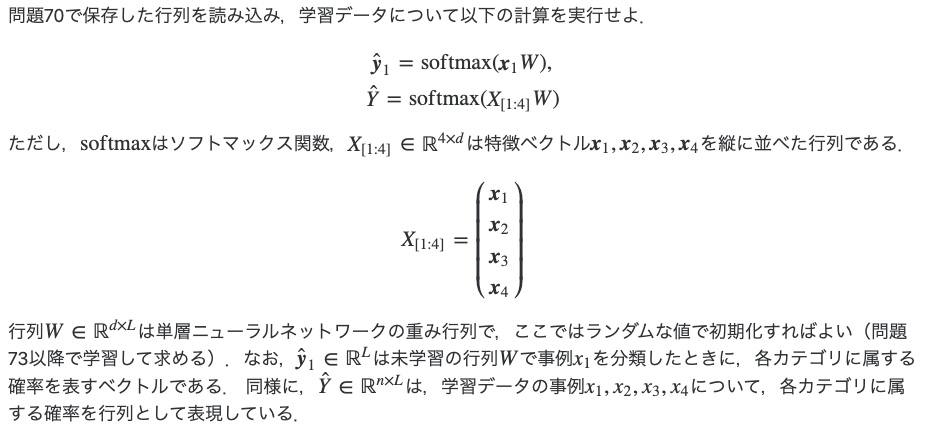

In [11]:
import torch

dtype = torch.float
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("device:", device)

device: cuda:0


In [12]:
with open("./datas_ch8/feature_matrices_train.csv", "r") as f:
    reader = csv.reader(f)
    for row in reader:
        feature_matrices_train_str = row
feature_matrices_train = []
for i in range(len(feature_matrices_train_str)):
    feature_matrix_train = [float(x) for x in feature_matrices_train_str[i][1:-1].split()]
    feature_matrix_train = np.array(feature_matrix_train)
    feature_matrices_train.append(feature_matrix_train)

with open("./datas_ch8/feature_matrices_valid.csv", "r") as f:
    reader = csv.reader(f)
    for row in reader:
        feature_matrices_valid_str = row
feature_matrices_valid = []
for i in range(len(feature_matrices_valid_str)):
    feature_matrix_valid = [float(x) for x in feature_matrices_valid_str[i][1:-1].split()]
    feature_matrix_valid = np.array(feature_matrix_valid)
    feature_matrices_valid.append(feature_matrix_valid)

with open("./datas_ch8/feature_matrices_test.csv", "r") as f:
    reader = csv.reader(f)
    for row in reader:
        feature_matrices_test_str = row
feature_matrices_test = []
for i in range(len(feature_matrices_test_str)):
    feature_matrix_test = [float(x) for x in feature_matrices_test_str[i][1:-1].split()]
    feature_matrix_test = np.array(feature_matrix_test)
    feature_matrices_test.append(feature_matrix_test)

In [13]:
#inputデータの欠損値処理
def create_input(feature_matrices):
    vectors = [x for x in feature_matrices]
    matrix = np.concatenate(vectors).reshape(len(vectors),300)
    input = torch.from_numpy(matrix)
    mask = torch.isnan(input)
    input[mask] = 0
    input = input.to(device)
    input = input.to(dtype)
    assert torch.isnan(input).any().item() == False
    assert torch.isinf(input).any().item() == False
    return input

feature_matrices_train = create_input(feature_matrices_train)
feature_matrices_valid = create_input(feature_matrices_valid)
feature_matrices_test = create_input(feature_matrices_test)

https://colab.research.google.com/github/YutaroOgawa/pytorch_tutorials_jp/blob/main/notebook/1_Learning%20PyTorch/1_3_neural_networks_tutorial_jp.ipynb#scrollTo=RJcJiwXgcJ8q

In [14]:
import torch
import torch.nn as nn
import torch.nn.functional as F
class SingleLayerNN(nn.Module):
    def __init__(self):
        super(SingleLayerNN, self).__init__()
        self.fc = nn.Linear(300, 4)
        torch.nn.init.xavier_uniform_(self.fc.weight, gain=1.0) #重みの初期値を設定
        nn.init.zeros_(self.fc.bias)    # バイアスの初期値を設定
        # inputは1つの行列、outputは各カテゴリに属する確率を表すベクトル

    def forward(self, x):
        x = self.fc(x)
        return x


In [15]:
print(type(feature_matrices_train[0].dtype))

<class 'torch.dtype'>


In [16]:
model = SingleLayerNN()
model = model.to(torch.float)
model = model.to(device)
print(model)

#1つのデータ(x1)に対して
# input_data = torch.from_numpy(feature_matrices_train[0])
input_data = feature_matrices_train[0]
input_data = input_data.to(device)
input_data = input_data.to(dtype)

x1_output = model(input_data)
print("x1に対するy_hat_1")
print(F.softmax(x1_output))

SingleLayerNN(
  (fc): Linear(in_features=300, out_features=4, bias=True)
)
x1に対するy_hat_1
tensor([0.2127, 0.2593, 0.2419, 0.2862], device='cuda:0',
       grad_fn=<SoftmaxBackward0>)


<ipython-input-16-8f5d2e9fa214>:14: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  print(F.softmax(x1_output))


In [28]:
#X[1:4]に対して

#ベクトルを縦に並べて行列を作成
vectors = [x for x in feature_matrices_train[0:4]]
# matrix = np.concatenate(vectors).reshape(4,300)

# vectorsをtorch.Tensorに変換
tensor = torch.stack([torch.Tensor(x) for x in vectors])

# テンソルをGPUに移動
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
tensor_gpu = tensor.to(device)

# input_data = torch.from_numpy(matrix)
input_data = input_data.to(device)
input_data = input_data.to(dtype)


X_output = model(input_data)
print("X[0:4]に対するY_hat")
print(F.softmax(X_output))

X[0:4]に対するY_hat
tensor([0.2127, 0.2593, 0.2419, 0.2862], device='cuda:0',
       grad_fn=<SoftmaxBackward0>)


<ipython-input-28-3d9cb97cd6f0>:21: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  print(F.softmax(X_output))


## 72. 損失と勾配の計算
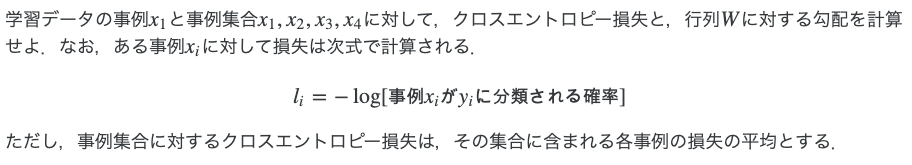

！注意！

$y_i$は$i$番目の事例の正解ラベルベクトルである。
行列$W\in \mathbb{R}^{d\times L}$であり、$d=特徴ベクトルの次元数(300)$、$L=ラベル数(4)$である。

In [29]:
model.train()
model.zero_grad()
for name, param in model.named_parameters():
    print(name, param.requires_grad)

fc.weight True
fc.bias True


In [30]:
with open("./datas_ch8/label_vectors_train.csv", "r") as f:
    reader = csv.reader(f)
    for row in reader:
        label_vectors_train_str = row
label_vectors_train = []
for i in range(len(label_vectors_train_str)):
    label_vector_train = int(label_vectors_train_str[i])
    label_vectors_train.append(label_vector_train)


with open("./datas_ch8/label_vectors_valid.csv", "r") as f:
    reader = csv.reader(f)
    for row in reader:
        label_vectors_valid_str = row
label_vectors_valid = []
for i in range(len(label_vectors_valid_str)):
    label_vector_valid = int(label_vectors_valid_str[i])
    label_vectors_valid.append(label_vector_valid)


with open("./datas_ch8/label_vectors_test.csv", "r") as f:
    reader = csv.reader(f)
    for row in reader:
        label_vectors_test_str = row
label_vectors_test = []
for i in range(len(label_vectors_test_str)):
    label_vector_test = int(label_vectors_test_str[i])
    label_vectors_test.append(label_vector_test)

In [31]:
label_vectors_test[0]

1

In [34]:
loss_fn = nn.CrossEntropyLoss()

# x_1に対して
input = torch.tensor(x1_output, requires_grad=True).unsqueeze(0)
input = input.to(device)
target = torch.tensor(label_vectors_train[0]).unsqueeze(0)
target = target.to(device)

print(input.requires_grad) # Trueと表示されるはず
print(target.requires_grad) # Falseと表示されるはず

loss = torch.tensor(loss_fn(input, target), requires_grad=True)
print(loss.requires_grad) # Trueと表示されるはず

print(loss)
model.zero_grad()
loss.backward()

True
False
True
tensor(1.3498, device='cuda:0', requires_grad=True)


<ipython-input-34-cb1f765383fe>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  input = torch.tensor(x1_output, requires_grad=True).unsqueeze(0)
<ipython-input-34-cb1f765383fe>:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  loss = torch.tensor(loss_fn(input, target), requires_grad=True)


In [35]:
# X[1:4]に対して
input = X_output
target = torch.tensor(label_vectors_train[0:4])
loss = torch.tensor(loss_fn(input, target), requires_grad=True)

loss
print(loss)
model.zero_grad()
loss.backward()

RuntimeError: ignored

In [36]:
# Wに対する勾配を取得する
for name, param in model.named_parameters():
    print(name, param.grad)

fc.weight None
fc.bias None


### 73. 確率的勾配降下法による学習
確率的勾配降下法（SGD: Stochastic Gradient Descent）を用いて，行列W
を学習せよ．なお，学習は適当な基準で終了させればよい（例えば「100エポックで終了」など）．

In [39]:
input.shape
print(input[0][1])

IndexError: ignored

In [38]:
# nanの位置を確認
nan_mask = torch.isnan(input)
input[nan_mask] = 0

# nanのインデックスを取得
nan_indices = torch.nonzero(nan_mask).tolist()
print(nan_indices)

for index in nan_indices:
    print("nan found at index:", index)
    input[index[0]][index[1]] = 0

[]


In [40]:
for name, param in model.named_parameters():
    if torch.isnan(param).any().item():
        print(f"'{name}' contains nan values")
    if torch.isinf(param).any().item():
        print(f"'{name}' contains inf values")

In [41]:
def contains_nan(dataloader):
    for batch in dataloader:
        feature_matrix, label_vector = batch
        if torch.isnan(feature_matrix).any() or torch.isnan(label_vector).any():
            print("has nan : batch = {}".format(batch))
            return True
        # print(feature_matrix.size())
    return False



In [42]:
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import TensorDataset


feature_matrices_train = torch.tensor(feature_matrices_train).to(dtype)
label_vectors_train = torch.tensor(label_vectors_train).to(dtype).type(torch.LongTensor)
train_data = TensorDataset(feature_matrices_train, label_vectors_train)

feature_matrices_valid = torch.tensor(feature_matrices_valid).to(dtype)
label_vectors_valid = torch.tensor(label_vectors_valid).to(dtype).type(torch.LongTensor)
valid_data = TensorDataset(feature_matrices_valid, label_vectors_valid)

feature_matrices_test = torch.tensor(feature_matrices_test).to(dtype)
label_vectors_test = torch.tensor(label_vectors_test).to(dtype).type(torch.LongTensor)
test_data = TensorDataset(feature_matrices_test, label_vectors_test)

<ipython-input-42-ebdc7f79e7d6>:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature_matrices_train = torch.tensor(feature_matrices_train).to(dtype)
<ipython-input-42-ebdc7f79e7d6>:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature_matrices_valid = torch.tensor(feature_matrices_valid).to(dtype)
<ipython-input-42-ebdc7f79e7d6>:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature_matrices_test = torch.tensor(feature_matrices_test).to(dtype)


In [43]:
print(feature_matrices_train[0].dtype)
print(label_vectors_train[0].dtype)

torch.float32
torch.int64


In [44]:
train_dataloader = DataLoader(train_data, batch_size=1, shuffle=True)
valid_dataloader = DataLoader(valid_data, batch_size=1, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=1, shuffle=True)


In [48]:
def train_loop(dataloader, model, loss_fn, optimizer):
    model.train()
    size = len(dataloader.dataset)
    for batch, (X, y) in enumerate(dataloader):
        y = y.to(device)
        pred = model(X)
        assert torch.isnan(pred).any().item() == False
        loss = loss_fn(pred, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 3000 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

def test_loop(dataloader, model, loss_fn):
    model.eval()
    size = len(dataloader.dataset)
    test_loss, correct = 0, 0

    with torch.no_grad():
        for X, y in dataloader:
            y = y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    test_loss /= size
    correct /= size
    print(f"Test Result: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")


In [49]:
model = SingleLayerNN()
model = model.to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

epochs = 10
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(train_dataloader, model, loss_fn, optimizer)
    test_loop(valid_dataloader, model, loss_fn)
print("Done!")

Epoch 1
-------------------------------
loss: 1.414084  [    0/10672]
loss: 1.885649  [ 3000/10672]
loss: 0.250778  [ 6000/10672]
loss: 0.652538  [ 9000/10672]
Test Result: 
 Accuracy: 82.7%, Avg loss: 0.515073 

Epoch 2
-------------------------------
loss: 0.229506  [    0/10672]
loss: 1.111070  [ 3000/10672]
loss: 1.086458  [ 6000/10672]
loss: 0.056255  [ 9000/10672]
Test Result: 
 Accuracy: 85.6%, Avg loss: 0.425193 

Epoch 3
-------------------------------
loss: 1.642812  [    0/10672]
loss: 0.028859  [ 3000/10672]
loss: 0.004591  [ 6000/10672]
loss: 2.837811  [ 9000/10672]
Test Result: 
 Accuracy: 86.9%, Avg loss: 0.384650 

Epoch 4
-------------------------------
loss: 0.035977  [    0/10672]
loss: 0.008122  [ 3000/10672]
loss: 0.060950  [ 6000/10672]
loss: 0.063190  [ 9000/10672]
Test Result: 
 Accuracy: 89.2%, Avg loss: 0.362012 

Epoch 5
-------------------------------
loss: 0.013801  [    0/10672]
loss: 0.119823  [ 3000/10672]
loss: 0.041072  [ 6000/10672]
loss: 0.059809  [ 

In [50]:
print(torch.isnan(input).any().item())
print(torch.isinf(input).any().item())


False
False


In [51]:
# Wに対する勾配を取得する
for name, param in model.named_parameters():
    print(name, param.grad)

fc.weight tensor([[ 0.0006,  0.0016, -0.0030,  ...,  0.0025,  0.0023, -0.0035],
        [-0.0050, -0.0122,  0.0235,  ..., -0.0197, -0.0179,  0.0272],
        [ 0.0039,  0.0097, -0.0186,  ...,  0.0156,  0.0141, -0.0215],
        [ 0.0004,  0.0010, -0.0019,  ...,  0.0015,  0.0014, -0.0021]],
       device='cuda:0')
fc.bias tensor([ 0.0371, -0.2874,  0.2276,  0.0226], device='cuda:0')


## 74. 正解率の計測
問題73で求めた行列を用いて学習データおよび評価データの事例を分類したとき，その正解率をそれぞれ求めよ．

In [52]:
# 重みの更新をストップ
for param in model.parameters():
    param.requires_grad = False

In [53]:
from sklearn.metrics import accuracy_score
def calculate_accuracy(model, input, y):
    preds = model(input).tolist()
    #まだ各ラベルの確立なので、argmaxで予測ラベルに変換する必要がある！
    preds = [np.argmax(pred) for pred in preds]
    return accuracy_score(y, preds)



In [54]:
print("train acc : {:>10}".format(calculate_accuracy(model, feature_matrices_train, label_vectors_train)))
print("test acc : {:>10}".format(calculate_accuracy(model, feature_matrices_test, label_vectors_test)))


train acc : 0.8904610194902549
test acc : 0.8695652173913043


## 75. 損失と正解率のプロット
問題73のコードを改変し，各エポックのパラメータ更新が完了するたびに，訓練データでの損失，正解率，検証データでの損失，正解率をグラフにプロットし，学習の進捗状況を確認できるようにせよ．

In [55]:
model = SingleLayerNN()

# 重みの更新を再開
for param in model.parameters():
    param.requires_grad = True

In [56]:
def calculate_accuracy_and_loss(model, dataloader, loss_fn):
    model.eval()
    total_loss = 0.0
    correct_predictions = 0
    total_samples = 0

    # 勾配の計算を無効にする
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)

            # 予測を計算
            outputs = model(inputs)

            # 損失を計算
            loss = loss_fn(outputs, labels)
            total_loss += loss.item() * inputs.size(0)

            # 予測の最大値のインデックスを取得（分類タスクの場合）
            _, predicted = torch.max(outputs, 1)

            # 正解数を計算
            correct_predictions += (predicted == labels).sum().item()
            total_samples += inputs.size(0)

    # 平均損失と正解率を計算
    average_loss = total_loss / total_samples
    accuracy = correct_predictions / total_samples

    return accuracy, average_loss



In [63]:
def train_loop(dataloader, model, loss_fn, optimizer, train_accs_list, train_losses_list):
    model.train()
    model.to(device)
    size = len(dataloader.dataset)
    for batch, (X, y) in enumerate(dataloader):
        y = y.to(device)
        pred = model(X)
        assert torch.isnan(pred).any().item() == False
        loss = loss_fn(pred, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 3000 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

    acc, loss = calculate_accuracy_and_loss(model, dataloader, loss_fn)
    print(f"Train Result: \n Accuracy: {(100*acc):>0.1f}%, Avg loss: {loss:>8f} \n")
    train_accs_list.append(acc)
    train_losses_list.append(loss)


def test_loop(dataloader, model, loss_fn, test_accs_list, test_losses_list):
    model.eval()
    size = len(dataloader.dataset)
    test_loss, correct = 0, 0

    with torch.no_grad():
        for X, y in dataloader:
            y = y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    test_loss /= size
    correct /= size
    acc, loss = calculate_accuracy_and_loss(model, dataloader, loss_fn)
    print(f"Test Result: \n Accuracy: {(100*acc):>0.1f}%, Avg loss: {loss:>8f} \n")
    test_accs_list.append(acc)
    test_losses_list.append(loss)

In [64]:
model = SingleLayerNN()
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

epochs = 10
train_accs, train_losses = [], []
valid_accs, valid_losses = [], []

for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(train_dataloader, model, loss_fn, optimizer, train_accs, train_losses)
    test_loop(valid_dataloader, model, loss_fn, valid_accs, valid_losses)
print("Done!")

Epoch 1
-------------------------------
loss: 1.256962  [    0/10672]
loss: 1.648530  [ 3000/10672]
loss: 0.300889  [ 6000/10672]
loss: 0.246263  [ 9000/10672]
Train Result: 
 Accuracy: 81.2%, Avg loss: 0.535563 

Test Result: 
 Accuracy: 81.9%, Avg loss: 0.517099 

Epoch 2
-------------------------------
loss: 0.275878  [    0/10672]
loss: 0.457434  [ 3000/10672]
loss: 1.198457  [ 6000/10672]
loss: 0.322719  [ 9000/10672]
Train Result: 
 Accuracy: 84.8%, Avg loss: 0.449894 

Test Result: 
 Accuracy: 85.5%, Avg loss: 0.426975 

Epoch 3
-------------------------------
loss: 0.062455  [    0/10672]
loss: 0.515789  [ 3000/10672]
loss: 0.947571  [ 6000/10672]
loss: 0.838503  [ 9000/10672]
Train Result: 
 Accuracy: 86.8%, Avg loss: 0.410924 

Test Result: 
 Accuracy: 88.4%, Avg loss: 0.386918 

Epoch 4
-------------------------------
loss: 1.377238  [    0/10672]
loss: 0.051971  [ 3000/10672]
loss: 0.129520  [ 6000/10672]
loss: 0.061659  [ 9000/10672]
Train Result: 
 Accuracy: 86.9%, Avg lo

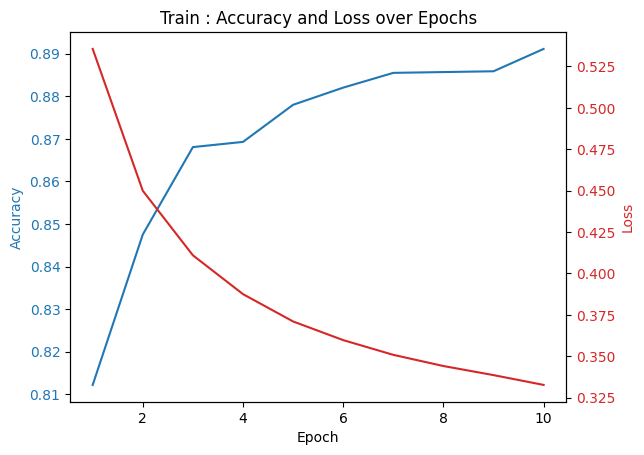

In [65]:
import matplotlib.pyplot as plt

epochs = [i for i in range(1, 11)]  # 10エポック分のデータと仮定

# グラフの初期設定
fig, ax1 = plt.subplots()

# ax1を使ってAccuracyをプロット
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy', color='tab:blue')
ax1.plot(epochs, train_accs, color='tab:blue', label='Accuracy')
ax1.tick_params(axis='y', labelcolor='tab:blue')

# ax2を作成 (ax1とx軸を共有)
ax2 = ax1.twinx()
ax2.set_ylabel('Loss', color='tab:red')
ax2.plot(epochs, train_losses, color='tab:red', label='Loss')
ax2.tick_params(axis='y', labelcolor='tab:red')

# グラフのタイトルと表示
plt.title("Train : Accuracy and Loss over Epochs")
plt.show()

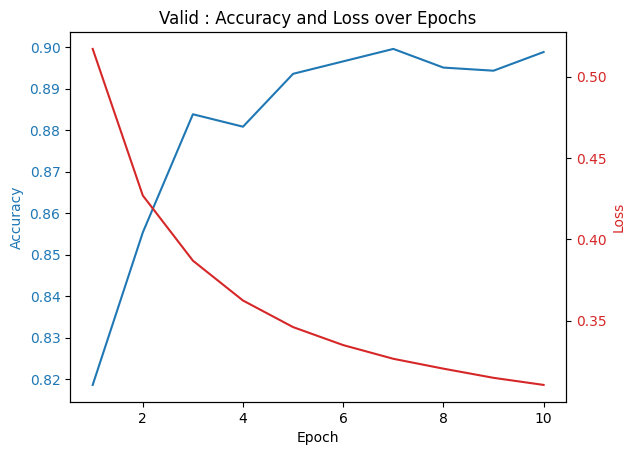

In [66]:
import matplotlib.pyplot as plt

epochs = [i for i in range(1, 11)]  # 10エポック分のデータと仮定

# グラフの初期設定
fig, ax1 = plt.subplots()

# ax1を使ってAccuracyをプロット
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy', color='tab:blue')
ax1.plot(epochs, valid_accs, color='tab:blue', label='Accuracy')
ax1.tick_params(axis='y', labelcolor='tab:blue')

# ax2を作成 (ax1とx軸を共有)
ax2 = ax1.twinx()
ax2.set_ylabel('Loss', color='tab:red')
ax2.plot(epochs, valid_losses, color='tab:red', label='Loss')
ax2.tick_params(axis='y', labelcolor='tab:red')

# グラフのタイトルと表示
plt.title("Valid : Accuracy and Loss over Epochs")
plt.show()


## 76. チェックポイント
問題75のコードを改変し，各エポックのパラメータ更新が完了するたびに，チェックポイント（学習途中のパラメータ（重み行列など）の値や最適化アルゴリズムの内部状態）をファイルに書き出せ．

In [68]:
#各epochのtrainが終わるたびにcheckpointを書き出しをするよう改変
def train_loop(dataloader, model, loss_fn, optimizer, train_accs_list, train_losses_list, epoch):
    model.train()
    size = len(dataloader.dataset)
    for batch, (X, y) in enumerate(dataloader):
        y = y.to(device)
        pred = model(X)
        assert torch.isnan(pred).any().item() == False
        loss = loss_fn(pred, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 3000 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

    acc, loss = calculate_accuracy_and_loss(model, dataloader, loss_fn)
    print(f"Train Result: \n Accuracy: {(100*acc):>0.1f}%, Avg loss: {loss:>8f} \n")
    train_accs_list.append(acc)
    train_losses_list.append(loss)
    # 学習情報の保存
    outfile = './datas_ch8/model_checkpoints/epoch{}_checkpoint.cpt'.format(epoch)
    torch.save({'epoch': epoch,
                'model_state_dict': model.state_dict(), #モデルの内部状態
                'opt_state_dict': optimizer.state_dict(), #optimizerの内部状態
                }, outfile)


In [70]:
model = SingleLayerNN()
model = model.to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

epochs = 10
train_accs, train_losses = [], []
valid_accs, valid_losses = [], []

for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(train_dataloader, model, loss_fn, optimizer, train_accs, train_losses, t)
    test_loop(valid_dataloader, model, loss_fn, valid_accs, valid_losses)
print("Done!")

Epoch 1
-------------------------------
loss: 1.329151  [    0/10672]
loss: 0.282782  [ 3000/10672]
loss: 0.536605  [ 6000/10672]
loss: 2.532651  [ 9000/10672]
Train Result: 
 Accuracy: 81.3%, Avg loss: 0.536393 

Test Result: 
 Accuracy: 82.5%, Avg loss: 0.517994 

Epoch 2
-------------------------------
loss: 0.160546  [    0/10672]
loss: 2.061331  [ 3000/10672]
loss: 0.024488  [ 6000/10672]
loss: 1.129735  [ 9000/10672]
Train Result: 
 Accuracy: 84.9%, Avg loss: 0.450785 

Test Result: 
 Accuracy: 85.4%, Avg loss: 0.427942 

Epoch 3
-------------------------------
loss: 0.061613  [    0/10672]
loss: 0.755698  [ 3000/10672]
loss: 0.706471  [ 6000/10672]
loss: 0.575877  [ 9000/10672]
Train Result: 
 Accuracy: 86.3%, Avg loss: 0.410378 

Test Result: 
 Accuracy: 87.2%, Avg loss: 0.386133 

Epoch 4
-------------------------------
loss: 1.211649  [    0/10672]
loss: 1.664000  [ 3000/10672]
loss: 0.224868  [ 6000/10672]
loss: 0.041816  [ 9000/10672]
Train Result: 
 Accuracy: 87.3%, Avg lo

## 77. ミニバッチ化
問題76のコードを改変し，B
事例ごとに損失・勾配を計算し，行列W
の値を更新せよ（ミニバッチ化）．B
の値を1,2,4,8,…
と変化させながら，1エポックの学習に要する時間を比較せよ．

In [74]:
import time

powers_of_two = [2**n for n in range(7)]
for BATCH_SIZE in powers_of_two:
    train_dataloader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
    valid_dataloader = DataLoader(valid_data, batch_size=BATCH_SIZE, shuffle=True)
    test_dataloader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=True)

    time_list = []

    model = SingleLayerNN()
    model = model.to(device)
    loss_fn = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

    epochs = 10
    train_accs, train_losses = [], []
    valid_accs, valid_losses = [], []

    for t in range(epochs):
        start_time = time.time()
        print(f"Epoch {t+1}\n-------------------------------")
        train_loop(train_dataloader, model, loss_fn, optimizer, train_accs, train_losses, t)
        test_loop(valid_dataloader, model, loss_fn, valid_accs, valid_losses)
        end_time = time.time()
        epoch_time = end_time - start_time
        time_list.append(epoch_time)
    avg_time = sum(time_list) / len(time_list)
    # print(avg_time)
    # print(type(avg_time))
    avg_time = str(avg_time)
    print("=" * 20)
    print("batch size : {}, avg time by epochs : {}".format(BATCH_SIZE, avg_time))
    print("=" * 20)


Epoch 1
-------------------------------
loss: 1.426065  [    0/10672]
loss: 0.781626  [ 3000/10672]
loss: 0.314794  [ 6000/10672]
loss: 2.315533  [ 9000/10672]
Train Result: 
 Accuracy: 80.9%, Avg loss: 0.536005 

Test Result: 
 Accuracy: 82.0%, Avg loss: 0.515826 

Epoch 2
-------------------------------
loss: 1.492093  [    0/10672]
loss: 1.421614  [ 3000/10672]
loss: 0.751642  [ 6000/10672]
loss: 0.053576  [ 9000/10672]
Train Result: 
 Accuracy: 84.6%, Avg loss: 0.449786 

Test Result: 
 Accuracy: 85.7%, Avg loss: 0.425406 

Epoch 3
-------------------------------
loss: 0.427094  [    0/10672]
loss: 0.107869  [ 3000/10672]
loss: 0.187974  [ 6000/10672]
loss: 0.329788  [ 9000/10672]
Train Result: 
 Accuracy: 87.2%, Avg loss: 0.413313 

Test Result: 
 Accuracy: 88.8%, Avg loss: 0.388860 

Epoch 4
-------------------------------
loss: 0.048138  [    0/10672]
loss: 0.013830  [ 3000/10672]
loss: 0.036634  [ 6000/10672]
loss: 0.099245  [ 9000/10672]
Train Result: 
 Accuracy: 87.0%, Avg lo

In [75]:
print(epochs)

10


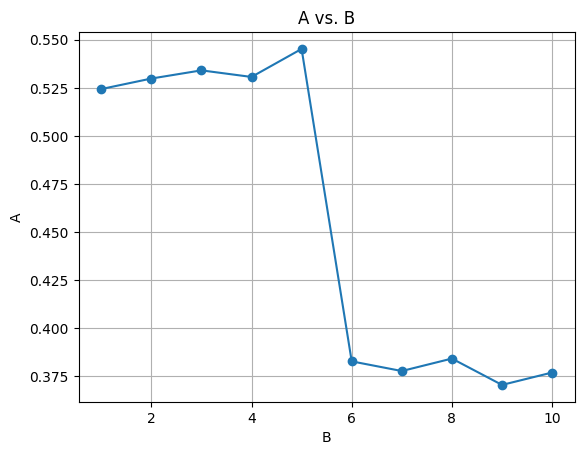

In [76]:
import matplotlib.pyplot as plt

epochs = [i for i in range(1, 11)]  # 10エポック分のデータと仮定

plt.plot(epochs, time_list, 'o-')  # 'o-' は点線のスタイルを意味します。
plt.xlabel('B')
plt.ylabel('A')
plt.title('A vs. B')
plt.grid(True)
plt.show()

## 78. GPU上での学習
問題77のコードを改変し，GPU上で学習を実行せよ

In [77]:
def train_loop(dataloader, model, loss_fn, optimizer, train_accs_list, train_losses_list, epoch):
    model.train()
    size = len(dataloader.dataset)
    for batch, (X, y) in enumerate(dataloader):
        X = X.to('cuda', non_blocking=True)
        y = y.to('cuda', non_blocking=True)
        pred = model(X)
        assert torch.isnan(pred).any().item() == False
        loss = loss_fn(pred, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 3000 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

    acc, loss = calculate_accuracy_and_loss(model, dataloader, loss_fn)
    print(f"Train Result: \n Accuracy: {(100*acc):>0.1f}%, Avg loss: {loss:>8f} \n")
    train_accs_list.append(acc)
    train_losses_list.append(loss)
    # 学習情報の保存
    outfile = './datas_ch8/model_checkpoints/epoch{}_checkpoint.cpt'.format(epoch)
    torch.save({'epoch': epoch,
                'model_state_dict': model.state_dict(), #モデルの内部状態
                'opt_state_dict': optimizer.state_dict(), #optimizerの内部状態
                }, outfile)


def test_loop(dataloader, model, loss_fn, test_accs_list, test_losses_list):
    model.eval()
    size = len(dataloader.dataset)
    test_loss, correct = 0, 0

    with torch.no_grad():
        for X, y in dataloader:
            X = X.to('cuda', non_blocking=True)
            y = y.to('cuda', non_blocking=True)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    test_loss /= size
    correct /= size
    acc, loss = calculate_accuracy_and_loss(model, dataloader, loss_fn)
    print(f"Test Result: \n Accuracy: {(100*acc):>0.1f}%, Avg loss: {loss:>8f} \n")
    test_accs_list.append(acc)
    test_losses_list.append(loss)

In [78]:
import time

powers_of_two = [2**n for n in range(7)]
for BATCH_SIZE in powers_of_two:
    train_dataloader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
    valid_dataloader = DataLoader(valid_data, batch_size=BATCH_SIZE, shuffle=True)
    test_dataloader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=True)

    time_list = []

    model = SingleLayerNN()
    model.to('cuda')
    loss_fn = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

    epochs = 10
    train_accs, train_losses = [], []
    valid_accs, valid_losses = [], []

    for t in range(epochs):
        start_time = time.time()
        print(f"Epoch {t+1}\n-------------------------------")
        train_loop(train_dataloader, model, loss_fn, optimizer, train_accs, train_losses, t)
        test_loop(valid_dataloader, model, loss_fn, valid_accs, valid_losses)
        end_time = time.time()
        epoch_time = end_time - start_time
        time_list.append(epoch_time)
    avg_time = sum(time_list) / len(time_list)
    # print(avg_time)
    # print(type(avg_time))
    avg_time = str(avg_time)
    print("=" * 20)
    print("batch size : {}, avg time by epochs : {}".format(BATCH_SIZE, avg_time))
    print("=" * 20)


Epoch 1
-------------------------------
loss: 1.272531  [    0/10672]
loss: 2.154756  [ 3000/10672]
loss: 0.639977  [ 6000/10672]
loss: 0.238611  [ 9000/10672]
Train Result: 
 Accuracy: 80.6%, Avg loss: 0.538579 

Test Result: 
 Accuracy: 81.8%, Avg loss: 0.518265 

Epoch 2
-------------------------------
loss: 0.019705  [    0/10672]
loss: 0.142591  [ 3000/10672]
loss: 2.908898  [ 6000/10672]
loss: 1.733937  [ 9000/10672]
Train Result: 
 Accuracy: 85.0%, Avg loss: 0.452830 

Test Result: 
 Accuracy: 86.1%, Avg loss: 0.428749 

Epoch 3
-------------------------------
loss: 1.468502  [    0/10672]
loss: 0.037890  [ 3000/10672]
loss: 2.341437  [ 6000/10672]
loss: 2.970938  [ 9000/10672]
Train Result: 
 Accuracy: 86.4%, Avg loss: 0.411897 

Test Result: 
 Accuracy: 87.3%, Avg loss: 0.385576 

Epoch 4
-------------------------------
loss: 0.199584  [    0/10672]
loss: 0.038371  [ 3000/10672]
loss: 0.049917  [ 6000/10672]
loss: 1.303452  [ 9000/10672]
Train Result: 
 Accuracy: 87.6%, Avg lo

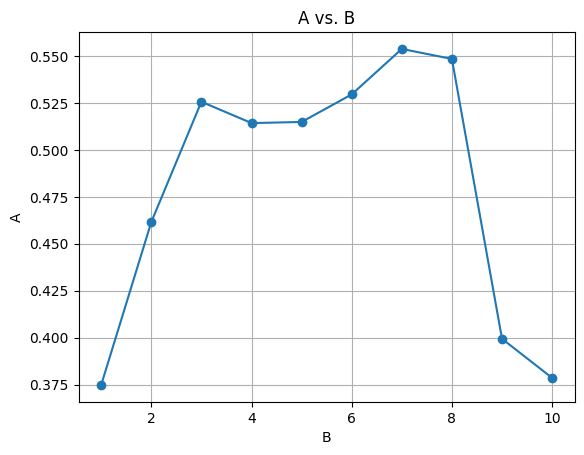

In [79]:
import matplotlib.pyplot as plt

epochs = [i for i in range(1, 11)]  # 10エポック分のデータと仮定

plt.plot(epochs, time_list, 'o-')  # 'o-' は点線のスタイルを意味します。
plt.xlabel('B')
plt.ylabel('A')
plt.title('A vs. B')
plt.grid(True)
plt.show()

## 79. 多層ニューラルネットワーク
問題78のコードを改変し，バイアス項の導入や多層化など，ニューラルネットワークの形状を変更しながら，高性能なカテゴリ分類器を構築せよ．

In [99]:
import torch.nn as nn
import torch

class MultiLayerNN(nn.Module):
    def __init__(self):
        super(MultiLayerNN, self).__init__()

        # 入力層から隠れ層1への線形変換
        self.fc1 = nn.Linear(300, 200)
        torch.nn.init.xavier_uniform_(self.fc1.weight, gain=1.0)
        nn.init.zeros_(self.fc1.bias)

        # 隠れ層1から隠れ層2への線形変換
        self.fc2 = nn.Linear(200, 100)
        torch.nn.init.xavier_uniform_(self.fc2.weight, gain=1.0)
        nn.init.zeros_(self.fc2.bias)

        # 隠れ層2から隠れ層3への線形変換
        self.fc3 = nn.Linear(100, 50)
        torch.nn.init.xavier_uniform_(self.fc3.weight, gain=1.0)
        nn.init.zeros_(self.fc3.bias)

        # 隠れ層3から出力層への線形変換
        self.fc4 = nn.Linear(50, 4)
        torch.nn.init.xavier_uniform_(self.fc4.weight, gain=1.0)
        nn.init.zeros_(self.fc4.bias)

    def forward(self, x):
        x = self.fc1(x)
        x = nn.ReLU()(x)

        x = self.fc2(x)
        x = nn.ReLU()(x)

        x = self.fc3(x)
        x = nn.ReLU()(x)

        x = self.fc4(x)
        return x


In [100]:
model = SingleLayerNN()

# 重みの更新を再開
for param in model.parameters():
    param.requires_grad = True

In [101]:
def calculate_accuracy_and_loss(model, dataloader, loss_fn):
    model.eval()
    total_loss = 0.0
    correct_predictions = 0
    total_samples = 0

    # 勾配の計算を無効にする
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)

            # 予測を計算
            outputs = model(inputs)

            # 損失を計算
            loss = loss_fn(outputs, labels)
            total_loss += loss.item() * inputs.size(0)

            # 予測の最大値のインデックスを取得（分類タスクの場合）
            _, predicted = torch.max(outputs, 1)

            # 正解数を計算
            correct_predictions += (predicted == labels).sum().item()
            total_samples += inputs.size(0)

    # 平均損失と正解率を計算
    average_loss = total_loss / total_samples
    accuracy = correct_predictions / total_samples

    return accuracy, average_loss



In [105]:
model = MultiLayerNN()
model = model.to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

epochs = 50
train_accs, train_losses = [], []
valid_accs, valid_losses = [], []

for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(train_dataloader, model, loss_fn, optimizer, train_accs, train_losses, t)
    test_loop(valid_dataloader, model, loss_fn, valid_accs, valid_losses)
print("Done!")

Epoch 1
-------------------------------
loss: 1.395322  [    0/10672]
Train Result: 
 Accuracy: 51.3%, Avg loss: 1.171102 

Test Result: 
 Accuracy: 51.8%, Avg loss: 1.169019 

Epoch 2
-------------------------------
loss: 1.125848  [    0/10672]
Train Result: 
 Accuracy: 73.9%, Avg loss: 1.037959 

Test Result: 
 Accuracy: 74.9%, Avg loss: 1.033360 

Epoch 3
-------------------------------
loss: 1.052718  [    0/10672]
Train Result: 
 Accuracy: 75.7%, Avg loss: 0.867905 

Test Result: 
 Accuracy: 76.8%, Avg loss: 0.861083 

Epoch 4
-------------------------------
loss: 0.692427  [    0/10672]
Train Result: 
 Accuracy: 77.0%, Avg loss: 0.728919 

Test Result: 
 Accuracy: 78.0%, Avg loss: 0.719885 

Epoch 5
-------------------------------
loss: 0.654507  [    0/10672]
Train Result: 
 Accuracy: 77.5%, Avg loss: 0.653310 

Test Result: 
 Accuracy: 78.4%, Avg loss: 0.643849 

Epoch 6
-------------------------------
loss: 0.537692  [    0/10672]
Train Result: 
 Accuracy: 78.1%, Avg loss: 0.

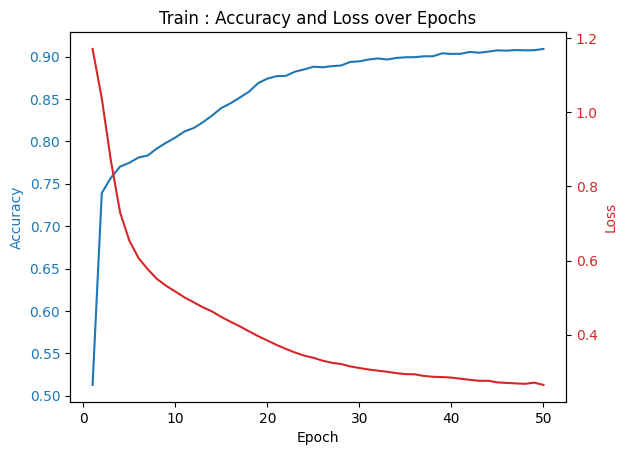

In [108]:
import matplotlib.pyplot as plt

epochs = [i for i in range(1, 51)]  # 10エポック分のデータと仮定

# グラフの初期設定
fig, ax1 = plt.subplots()

# ax1を使ってAccuracyをプロット
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy', color='tab:blue')
ax1.plot(epochs, train_accs, color='tab:blue', label='Accuracy')
ax1.tick_params(axis='y', labelcolor='tab:blue')

# ax2を作成 (ax1とx軸を共有)
ax2 = ax1.twinx()
ax2.set_ylabel('Loss', color='tab:red')
ax2.plot(epochs, train_losses, color='tab:red', label='Loss')
ax2.tick_params(axis='y', labelcolor='tab:red')

# グラフのタイトルと表示
plt.title("Train : Accuracy and Loss over Epochs")
plt.show()

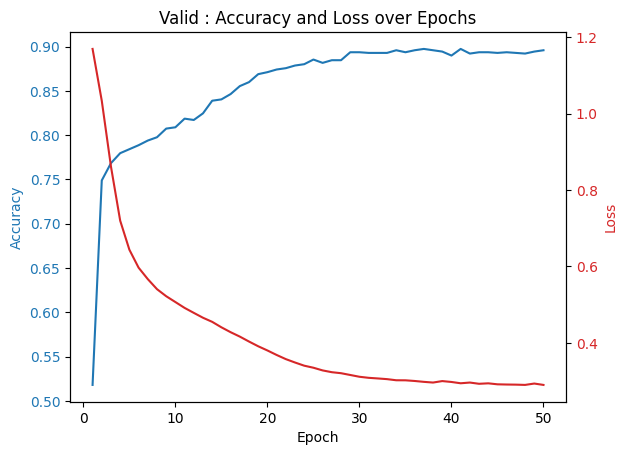

In [109]:
import matplotlib.pyplot as plt

epochs = [i for i in range(1, 51)]  # 10エポック分のデータと仮定

# グラフの初期設定
fig, ax1 = plt.subplots()

# ax1を使ってAccuracyをプロット
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy', color='tab:blue')
ax1.plot(epochs, valid_accs, color='tab:blue', label='Accuracy')
ax1.tick_params(axis='y', labelcolor='tab:blue')

# ax2を作成 (ax1とx軸を共有)
ax2 = ax1.twinx()
ax2.set_ylabel('Loss', color='tab:red')
ax2.plot(epochs, valid_losses, color='tab:red', label='Loss')
ax2.tick_params(axis='y', labelcolor='tab:red')

# グラフのタイトルと表示
plt.title("Valid : Accuracy and Loss over Epochs")
plt.show()
